In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.linalg import eigh
import qutip as qt
import sympy as sym
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

In [2]:
fF  = 1e-15
nH  = 1e-9
GHz = 1e9

# Study of the individual charge-charge couplings that appear between the resonators and the qubits

In [3]:
n_eig = 6
nmax_r = 10
nmax_f = 15

LR_1 = 100
LR_2 = 140
LR_3 = 130

Δ_1  = 0.1
Δ_2  = 0.15
Δ_3  = 0.12

CC_values = np.geomspace(1e-3, 1e0, 10)
only_inner = True
compensate_extra_cap = False

In [4]:
CR_1, CF_1, LF_1, LR_1, EJ_1, Δ_1, ω_r_1 = sq_ext.get_experimental_parameters('qubit_1')
CR_2, CF_2, LF_2, LR_2, EJ_2, Δ_2, ω_r_2 = sq_ext.get_experimental_parameters('qubit_2')
CR_3, CF_3, LF_3, LR_3, EJ_3, Δ_3, ω_r_3 = sq_ext.get_experimental_parameters('qubit_3')


# Qubit 1 - Coupler at operation point

In [5]:
FF_p1  = np.zeros([2, len(CC_values), 4, 4], dtype='complex')
FF_p2  = np.zeros([2, len(CC_values), 4, 4], dtype='complex')
FF_SWT = np.zeros([2, len(CC_values), 4, 4], dtype='complex')
FF_Δω  = np.zeros(len(CC_values))

FR_p1  = np.zeros([2, len(CC_values), 4, 4], dtype='complex')
FR_p2  = np.zeros([2, len(CC_values), 4, 4], dtype='complex')
FR_SWT = np.zeros([2, len(CC_values), 4, 4], dtype='complex')
FR_Δω  = np.zeros(len(CC_values))

RR_p1  = np.zeros([2, len(CC_values), 4, 4], dtype='complex')
RR_p2  = np.zeros([2, len(CC_values), 4, 4], dtype='complex')
RR_SWT = np.zeros([2, len(CC_values), 4, 4], dtype='complex')
RR_Δω  = np.zeros(len(CC_values))

g_r_limit =np.zeros(len(CC_values))
g_fq_limit=np.zeros(len(CC_values))

for i, CC in enumerate(CC_values):
    print(i)
    
    C_mat = sq_ext.C_mat_qubit_C_qubit(CC, CR_1, CF_1, CR_2, CF_2, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap)
    C_inv = np.linalg.inv(C_mat)
    CF_1_tilde, CR_1_tilde, CF_2_tilde, CR_2_tilde = np.diag(C_inv) ** -1
    
    F1 = sq_ext.sq_fluxonium(C_F_eff=CF_1_tilde, L_F_eff=LF_1, Δ=Δ_1, EJ=EJ_1, nmax_f=nmax_f)
    R1 = sq_ext.sq_resonator(C_R_eff=CR_1_tilde, L_R_eff=LR_1, Δ=Δ_1, EJ=EJ_1, nmax_r=nmax_r)
    F2 = sq_ext.sq_fluxonium(C_F_eff=CF_2_tilde, L_F_eff=LF_2, Δ=Δ_2, EJ=EJ_2, nmax_f=nmax_f)
    R2 = sq_ext.sq_resonator(C_R_eff=CR_2_tilde, L_R_eff=LR_2, Δ=Δ_2, EJ=EJ_2, nmax_r=nmax_r)
    
    H_F1 = F1.hamiltonian()
    H_R1 = R1.hamiltonian()
        
    # Move the coupler to the resonance point
    φ_ext_resonance = sq_ext.find_resonance(H_F1, F2)
    loop = F2.loops[0]
    loop.set_flux(φ_ext_resonance)
    
    H_F2 = F2.hamiltonian()
    H_R2 = R2.hamiltonian()
    
    I_F  = qt.identity(H_F1.dims[0])
    I_R  = qt.identity(H_R1.dims[0])
    
    Q_F1 = F1.charge_op(0)
    Q_R1 = R1.charge_op(0)
    Q_F2 = F2.charge_op(0)
    Q_R2 = R2.charge_op(0)
    
    H0_FF = qt.tensor(H_F1,I_F) + qt.tensor(I_F,H_F2)   
    H0_FR = qt.tensor(H_F1,I_R) + qt.tensor(I_F,H_R2)
    H0_RR = qt.tensor(H_R1,I_R) + qt.tensor(I_R,H_R2)

    H_FF = H0_FF + C_inv[0,2] * fF**-1 * qt.tensor(Q_F1,Q_F2)   
    H_FR = H0_FR + C_inv[0,3] * fF**-1 * qt.tensor(Q_F1,Q_R2)   
    H_RR = H0_RR + C_inv[1,3] * fF**-1 * qt.tensor(Q_R1,Q_R2)


    for p1, p2, SWT, Δω, H_0, H, H1, H2 in zip([FF_p1,FR_p1,RR_p1],[FF_p2,FR_p2,RR_p2],[FF_SWT,FR_SWT,RR_SWT],[FF_Δω,FR_Δω,RR_Δω],[H0_FF,H0_FR,H0_RR],[H_FF,H_FR,H_RR], [H_F1, H_F1, H_R1], [H_F2, H_R2, H_R2]):
        
        # Composite method
        
        ψ_0         = qt.Qobj(sq_ext.diag(H1, n_eig=2,solver='numpy', real=True)[1][:,0])
        ψ_1         = qt.Qobj(sq_ext.diag(H1, n_eig=2,solver='numpy', real=True)[1][:,1])
        ψ_0_prime   = qt.Qobj(sq_ext.diag(H2, n_eig=2,solver='numpy', real=True)[1][:,0])
        ψ_1_prime   = qt.Qobj(sq_ext.diag(H2, n_eig=2,solver='numpy', real=True)[1][:,1])
        
        ψ_0 = [qt.tensor(ψ_0, ψ_0_prime), qt.tensor(ψ_0,ψ_1_prime), qt.tensor(ψ_1,ψ_0_prime),qt.tensor(ψ_1,ψ_1_prime)]
        
        E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]
        E_0  = sq_ext.diag(H_0  , n_eig=len(ψ_0)+2, out='GHz', solver='scipy')[0]
        E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0)+2, out='GHz', solver='Qutip', qObj=True)
        
        # print(E_0_ψ_0, E_0)
        # subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
        # print( sq_ext.find_close_indices(E_0_ψ_0, E_0))
        Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_0, H_fluxonium=H1, H_resonator=H2, n_eig=6)
        subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
        # print(subspace_indices)
        
        ψ = ψ[subspace_indices]
        E = E[subspace_indices]
        V = H-H_0
        
        H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0, H)
        H_eff_p2  = sq_ext.H_eff_p2_large (ψ_0, ψ, E_0, E, V,  remove_ground=True)
        H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True)
        
        p1 [0, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1,  print_pretty=False)
        p2 [0, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2,  print_pretty=False)
        SWT[0, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT, print_pretty=False)
        Δω[i]    = H_eff_SWT[2,2]-H_eff_SWT[1,1]
        
        
        # Direct method
        H_eff_p1  = sq_ext.H_eff_p1 (H_0, H, n_eig, real=True, remove_ground=True)
        H_eff_p2  = sq_ext.H_eff_p2 (H_0, H, n_eig, real=True, remove_ground=True)
        H_eff_SWT = sq_ext.H_eff_SWT(H_0, H, n_eig, real=True, remove_ground=True)
        
        Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_0, H_fluxonium=H1, H_resonator=H2, n_eig=6)
        subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
        
        H_eff_p1_subspace   = H_eff_p1  [subspace_indices][:, subspace_indices]
        H_eff_p2_subspace   = H_eff_p2  [subspace_indices][:, subspace_indices]
        H_eff_SWT_subspace  = H_eff_SWT [subspace_indices][:, subspace_indices]
        
        p1 [1, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1_subspace  ,  print_pretty=False)
        p2 [1, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2_subspace  ,  print_pretty=False)
        SWT[1, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT_subspace , print_pretty=False)
        Δω[i]    = H_eff_SWT[2,2]-H_eff_SWT[1,1]
    
    # # Analytic estimation of coupling
    # Lq = L_F_eff
    # # Lr = L_R_eff
    # C_f = C_F_eff_1 * fF
    # C_r = C_R_eff * fF  
    # l = Lq*(Lq+4*Lr) - 4*Δ**2
    # Lf = l/(Lq+4*Lr)
    # Lres = l/Lq
    # L_f = Lf * nH
    # L_r = Lres * nH
    # E_L_f = sq_ext.L_to_EL(Lf)
    # V =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    # φ_min = sp.optimize.minimize_scalar(V).x
    # Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    # Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt(L_f/C_f))
    # Φ_r_01 = np.sqrt(0.5*np.sqrt(L_r/C_r))
    # g_fq_limit[i] = 2 * Δ / (l * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    # g_r_limit[i] = 2 * Δ / (l * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    

0


C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:901: ComplexWarning: Casting complex values to real discards the imaginary part
  H_eff[i, j] = (ψ_0[i].dag() * H * ψ_0[j]).data[0, 0]
C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:1519: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, j] = 0.25 * (np.dot(S.T.conjugate(), A)).trace() # P[i,j]=(1/4)tr(S_ij^t*A)
C:\Users\gabri\AppData\Local\Temp\ipykernel_564\3493822926.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  Δω[i]    = H_eff_SWT[2,2]-H_eff_SWT[1,1]


1
2
3
4
5
6
7
8
9


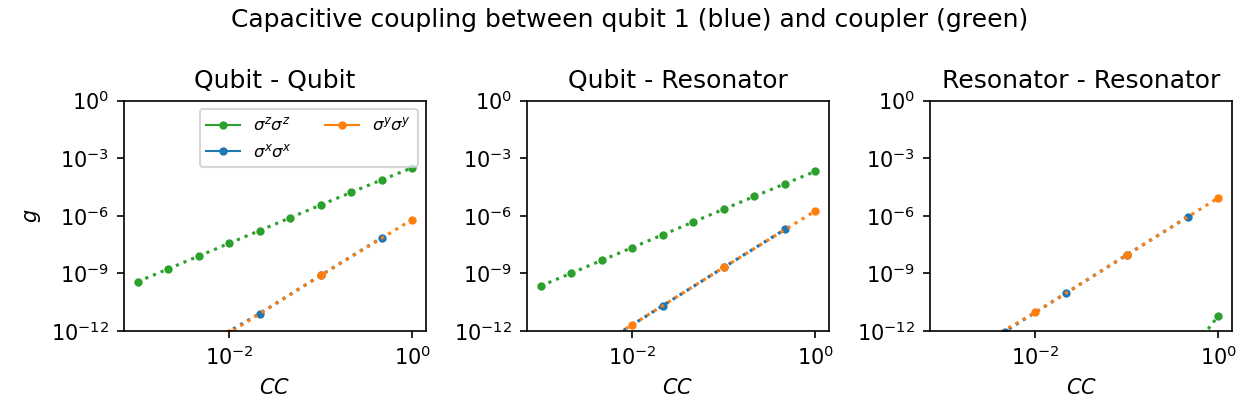

In [15]:
fig, axs = plt.subplots(ncols=3, figsize =np.array([3.5*3,3.5])*0.8, dpi=150)
linestyles = ['-', '--',':' ]
linewidths = [1, 1.5, 1.5]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

colors = figs.generate_colors_from_colormap(10, 'tab10')

for j, (ax, Pauli_list, Δω, name, labels) in enumerate(zip(axs, [[FF_p1 , FF_p2 , FF_SWT], [FR_p1 , FR_p2 , FR_SWT], [RR_p1, RR_p2, RR_SWT]], [FF_Δω, FR_Δω, RR_Δω], names, labels_list)):
    for i, Pauli in enumerate(Pauli_list):
        # if i ==1: 
        #     continue
        
        σxσx = np.abs(Pauli[0, :, 1,1]-Pauli[1, :, 1,1])
        σyσy = np.abs(Pauli[0, :, 2,2]-Pauli[1, :, 2,2])
        σzσz = np.abs(Pauli[0, :, 3,3]-Pauli[1, :, 3,3])
    
        ax.plot(CC_values, σzσz, '.' ,color = colors[2], linestyle=linestyles[i], label = labels[2], linewidth = linewidths[i])
        ax.plot(CC_values[::2], σxσx[::2], '.' ,color = colors[0], linestyle=linestyles[i], label = labels[0], linewidth = linewidths[i])
        ax.plot(CC_values[::3], σyσy[::3], '.' ,color = colors[1], linestyle=linestyles[i], label = labels[1], linewidth = linewidths[i])
        # ax.plot(CC_values, Δω/10, color = colors[3], linestyle=linestyles[i], label = r'$(\omega_A-\omega_B)/10$', linewidth = linewidths[i])
    
        # ax1.plot(Δ_values, g_fq_limit, 'x', color = colors[0], label = 'Fluxon limit', markersize='2')
        # ax1.plot(Δ_values, g_r_limit , 's', color = colors[0], label = 'Plasmon limit', markersize='2')
        if i ==0 and j ==0:
            ax.legend(ncol=2, fontsize=8)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-12,1e0])
        # ax.set_xlim([1e-2,1e0])
        if j==0:
            ax.set_ylabel('$g$')
        # else:
        #     ax.set_yticks([])
        ax.set_xlabel('$CC$')
        
        ax.set_title(name)
    
# fig.suptitle(r' --- P1 $\quad \cdots$ SWT')
fig.suptitle(r'Capacitive coupling between qubit 1 (blue) and coupler (green)')
fig.tight_layout()
# figs.export('Capacitive_coupling_ops_vs_CC_qubit_1_and_coupler.pdf', fig)
fig.show()

In [16]:
FF_p1  = np.zeros([len(CC_values), 4, 4], dtype='complex')
FF_p2  = np.zeros([len(CC_values), 4, 4], dtype='complex')
FF_SWT = np.zeros([len(CC_values), 4, 4], dtype='complex')
FF_Δω  = np.zeros(len(CC_values))

FR_p1  = np.zeros([len(CC_values), 4, 4], dtype='complex')
FR_p2  = np.zeros([len(CC_values), 4, 4], dtype='complex')
FR_SWT = np.zeros([len(CC_values), 4, 4], dtype='complex')
FR_Δω  = np.zeros(len(CC_values))

RR_p1  = np.zeros([len(CC_values), 4, 4], dtype='complex')
RR_p2  = np.zeros([len(CC_values), 4, 4], dtype='complex')
RR_SWT = np.zeros([len(CC_values), 4, 4], dtype='complex')
RR_Δω  = np.zeros(len(CC_values))

g_r_limit =np.zeros(len(CC_values))
g_fq_limit=np.zeros(len(CC_values))

for i, CC in enumerate(CC_values):
    print(i)
    
    C_mat = sq_ext.C_mat_qubit_C_qubit(CC, CR_1, CF_1, CR_2, CF_2, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap)
    C_inv = np.linalg.inv(C_mat)
    CF_1_tilde, CR_1_tilde, CF_2_tilde, CR_2_tilde = np.diag(C_inv) ** -1
    
    F1 = sq_ext.sq_fluxonium(C_F_eff=CF_1_tilde, L_F_eff=LF_1, Δ=Δ_1, EJ=EJ_1, nmax_f=nmax_f)
    R1 = sq_ext.sq_resonator(C_R_eff=CR_1_tilde, L_R_eff=LR_1, Δ=Δ_1, EJ=EJ_1, nmax_r=nmax_r)
    F2 = sq_ext.sq_fluxonium(C_F_eff=CF_2_tilde, L_F_eff=LF_2, Δ=Δ_2, EJ=EJ_2, nmax_f=nmax_f)
    R2 = sq_ext.sq_resonator(C_R_eff=CR_2_tilde, L_R_eff=LR_2, Δ=Δ_2, EJ=EJ_2, nmax_r=nmax_r)
    
    H_F1 = F1.hamiltonian()
    H_R1 = R1.hamiltonian()
        
    # Move the coupler to the resonance point
    φ_ext_resonance = sq_ext.find_resonance(H_F1, F2)
    loop = F2.loops[0]
    loop.set_flux(φ_ext_resonance)
    
    H_F2 = F2.hamiltonian()
    H_R2 = R2.hamiltonian()
    
    I_F  = qt.identity(H_F1.dims[0])
    I_R  = qt.identity(H_R1.dims[0])
    
    Q_F1 = F1.charge_op(0)
    Q_R1 = R1.charge_op(0)
    Q_F2 = F2.charge_op(0)
    Q_R2 = R2.charge_op(0)
    
    H0_FF = qt.tensor(H_F1,I_F) + qt.tensor(I_F,H_F2)   
    H0_FR = qt.tensor(H_F1,I_R) + qt.tensor(I_F,H_R2)
    H0_RR = qt.tensor(H_R1,I_R) + qt.tensor(I_R,H_R2)

    H_FF = H0_FF + C_inv[0,2] * fF**-1 * qt.tensor(Q_F1,Q_F2)   
    H_FR = H0_FR + C_inv[0,3] * fF**-1 * qt.tensor(Q_F1,Q_R2)   
    H_RR = H0_RR + C_inv[1,3] * fF**-1 * qt.tensor(Q_R1,Q_R2)


    for p1, p2, SWT, Δω, H_0, H, H1, H2 in zip([FF_p1,FR_p1,RR_p1],[FF_p2,FR_p2,RR_p2],[FF_SWT,FR_SWT,RR_SWT],[FF_Δω,FR_Δω,RR_Δω],[H0_FF,H0_FR,H0_RR],[H_FF,H_FR,H_RR], [H_F1, H_F1, H_R1], [H_F2, H_R2, H_R2]):
        H_eff_p1  = sq_ext.H_eff_p1 (H_0, H, n_eig, real=True, remove_ground=True)
        # H_eff_p2  = sq_ext.H_eff_p2 (H_0, H, n_eig, real=True, remove_ground=True)
        H_eff_SWT = sq_ext.H_eff_SWT(H_0, H, n_eig, real=True, remove_ground=True)
        
        # if i ==0:
        Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_0, H_fluxonium=H1, H_resonator=H2, n_eig=6)
        subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
        
        H_eff_p1_subspace   = H_eff_p1  [subspace_indices][:, subspace_indices]
        # H_eff_p2_subspace   = H_eff_p2  [subspace_indices][:, subspace_indices]
        H_eff_SWT_subspace  = H_eff_SWT [subspace_indices][:, subspace_indices]
    
        
        p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1_subspace  ,  print_pretty=False)
        # p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2_subspace  ,  print_pretty=False)
        SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT_subspace , print_pretty=False)
        Δω[i]    = H_eff_SWT[2,2]-H_eff_SWT[1,1]
    
    # # Analytic estimation of coupling
    # Lq = L_F_eff
    # # Lr = L_R_eff
    # C_f = C_F_eff_1 * fF
    # C_r = C_R_eff * fF  
    # l = Lq*(Lq+4*Lr) - 4*Δ**2
    # Lf = l/(Lq+4*Lr)
    # Lres = l/Lq
    # L_f = Lf * nH
    # L_r = Lres * nH
    # E_L_f = sq_ext.L_to_EL(Lf)
    # V =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    # φ_min = sp.optimize.minimize_scalar(V).x
    # Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    # Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt(L_f/C_f))
    # Φ_r_01 = np.sqrt(0.5*np.sqrt(L_r/C_r))
    # g_fq_limit[i] = 2 * Δ / (l * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    # g_r_limit[i] = 2 * Δ / (l * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    

0
1
2
3
4
5
6
7
8
9


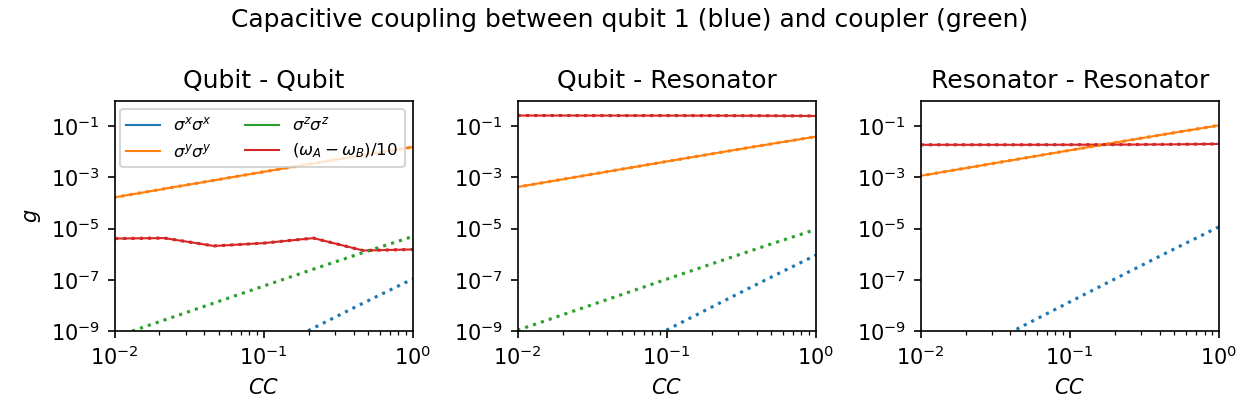

In [17]:
fig, axs = plt.subplots(ncols=3, figsize =np.array([3.5*3,3.5])*0.8, dpi=150)
linestyles = ['-', '--',':' ]
linewidths = [1, 1.5, 1.5]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

colors = figs.generate_colors_from_colormap(10, 'tab10')

for j, (ax, Pauli_list, Δω, name, labels) in enumerate(zip(axs, [[FF_p1 , FF_p2 , FF_SWT], [FR_p1 , FR_p2 , FR_SWT], [RR_p1, RR_p2, RR_SWT]], [FF_Δω, FR_Δω, RR_Δω], names, labels_list)):
    for i, Pauli in enumerate(Pauli_list):
        if i ==1: 
            continue
        
        σxσx = np.abs(Pauli[:, 1,1])
        σyσy = np.abs(Pauli[:, 2,2])
        σzσz = np.abs(Pauli[:, 3,3])
    
        ax.plot(CC_values, σxσx,  color = colors[0], linestyle=linestyles[i], label = labels[0], linewidth = linewidths[i])
        ax.plot(CC_values, σyσy,  color = colors[1], linestyle=linestyles[i], label = labels[1], linewidth = linewidths[i])
        ax.plot(CC_values, σzσz,  color = colors[2], linestyle=linestyles[i], label = labels[2], linewidth = linewidths[i])
        ax.plot(CC_values, Δω/10, color = colors[3], linestyle=linestyles[i], label = r'$(\omega_A-\omega_B)/10$', linewidth = linewidths[i])
    
        # ax1.plot(Δ_values, g_fq_limit, 'x', color = colors[0], label = 'Fluxon limit', markersize='2')
        # ax1.plot(Δ_values, g_r_limit , 's', color = colors[0], label = 'Plasmon limit', markersize='2')
        if i ==0 and j ==0:
            ax.legend(ncol=2, fontsize=8)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-9,1e0])
        ax.set_xlim([1e-2,1e0])
        if j==0:
            ax.set_ylabel('$g$')
        # else:
        #     ax.set_yticks([])
        ax.set_xlabel('$CC$')
        
        ax.set_title(name)
    
# fig.suptitle(r' --- P1 $\quad \cdots$ SWT')
fig.suptitle(r'Capacitive coupling between qubit 1 (blue) and coupler (green)')
fig.tight_layout()
# figs.export('Capacitive_coupling_ops_vs_CC_qubit_1_and_coupler.pdf', fig)
fig.show()

# Coupler - Qubit 2 at operation point

In [12]:
FF_p1  = np.zeros([len(CC_values), 4, 4])
FF_p2  = np.zeros([len(CC_values), 4, 4])
FF_SWT = np.zeros([len(CC_values), 4, 4])
FF_Δω  = np.zeros(len(CC_values))

FR_p1  = np.zeros([len(CC_values), 4, 4])
FR_p2  = np.zeros([len(CC_values), 4, 4])
FR_SWT = np.zeros([len(CC_values), 4, 4])
FR_Δω  = np.zeros(len(CC_values))

RR_p1  = np.zeros([len(CC_values), 4, 4])
RR_p2  = np.zeros([len(CC_values), 4, 4])
RR_SWT = np.zeros([len(CC_values), 4, 4])
RR_Δω  = np.zeros(len(CC_values))

g_r_limit =np.zeros(len(CC_values))
g_fq_limit=np.zeros(len(CC_values))

for i, CC in enumerate(CC_values):
    
    # First find the frequency of the qubit 1, because that gives the operation point
    C_mat = sq_ext.C_mat_qubit_C_qubit(CC, CR_1, CF_1, CR_2, CF_2, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap)
    C_inv = np.linalg.inv(C_mat)
    CF_1_tilde, CR_1_tilde, CF_2_tilde, CR_2_tilde = np.diag(C_inv) ** -1
    
    F0 = sq_ext.sq_fluxonium(C_F_eff=CF_1_tilde, L_F_eff=LF_1, Δ=Δ_1, EJ=EJ_1, nmax_f=nmax_f)
    H_F0 = F0.hamiltonian()
    # Then create the actual coupler and qubit 2
    
    C_mat = sq_ext.C_mat_qubit_C_qubit(CC, CR_2, CF_2, CR_3, CF_3, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap)
    C_inv = np.linalg.inv(C_mat)
    CF_2_tilde, CR_2_tilde, CF_3_tilde, CR_3_tilde = np.diag(C_inv) ** -1
    
    F1 = sq_ext.sq_fluxonium(C_F_eff=CF_2_tilde, L_F_eff=LF_2, Δ=Δ_2, EJ=EJ_2, nmax_f=nmax_f)
    R1 = sq_ext.sq_resonator(C_R_eff=CR_2_tilde, L_R_eff=LR_2, Δ=Δ_2, EJ=EJ_2, nmax_r=nmax_r)
    F2 = sq_ext.sq_fluxonium(C_F_eff=CF_3_tilde, L_F_eff=LF_3, Δ=Δ_3, EJ=EJ_3, nmax_f=nmax_f)
    R2 = sq_ext.sq_resonator(C_R_eff=CR_3_tilde, L_R_eff=LR_3, Δ=Δ_3, EJ=EJ_3, nmax_r=nmax_r)

    # Move the coupler to the resonance point
    φ_ext_resonance1 = sq_ext.find_resonance(H_F0, F1)
    loop1 = F1.loops[0]
    loop1.set_flux(φ_ext_resonance1)
    
    # Move the qubit 2 to the resonance point
    φ_ext_resonance2 = sq_ext.find_resonance(H_F0, F2)
    loop2 = F2.loops[0]
    loop2.set_flux(φ_ext_resonance2)
    
    # Continue, now the indices 1 correspond to the coupler and 2 to the qubit 2
    H_F1 = F1.hamiltonian()
    H_R1 = R1.hamiltonian()
    H_F2 = F2.hamiltonian()
    H_R2 = R2.hamiltonian()
    
    I_F  = qt.identity(H_F1.dims[0])
    I_R  = qt.identity(H_R1.dims[0])
    
    Q_F1 = F1.charge_op(0)
    Q_R1 = R1.charge_op(0)
    Q_F2 = F2.charge_op(0)
    Q_R2 = R2.charge_op(0)
    
    H0_FF = qt.tensor(H_F1,I_F) + qt.tensor(I_F,H_F2)   
    H0_FR = qt.tensor(H_F1,I_R) + qt.tensor(I_F,H_R2)
    H0_RR = qt.tensor(H_R1,I_R) + qt.tensor(I_R,H_R2)

    H_FF = H0_FF + C_inv[0,2] * fF**-1 * qt.tensor(Q_F1,Q_F2)   
    H_FR = H0_FR + C_inv[0,3] * fF**-1 * qt.tensor(Q_F1,Q_R2)   
    H_RR = H0_RR + C_inv[1,3] * fF**-1 * qt.tensor(Q_R1,Q_R2)


    for p1, p2, SWT, Δω, H_0, H, H1, H2 in zip([FF_p1,FR_p1,RR_p1],[FF_p2,FR_p2,RR_p2],[FF_SWT,FR_SWT,RR_SWT],[FF_Δω,FR_Δω,RR_Δω],[H0_FF,H0_FR,H0_RR],[H_FF,H_FR,H_RR], [H_F1, H_F1, H_R1], [H_F2, H_R2, H_R2]):
        H_eff_p1  = sq_ext.H_eff_p1 (H_0, H, n_eig, real=True, remove_ground=True)
        H_eff_p2  = sq_ext.H_eff_p2 (H_0, H, n_eig, real=True, remove_ground=True)
        H_eff_SWT = sq_ext.H_eff_SWT(H_0, H, n_eig, real=True, remove_ground=True)
        
        # if i ==0:
        Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_0, H_fluxonium=H1, H_resonator=H2, n_eig=6)
        subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
        
        H_eff_p1_subspace   = H_eff_p1  [subspace_indices][:, subspace_indices]
        H_eff_p2_subspace   = H_eff_p2  [subspace_indices][:, subspace_indices]
        H_eff_SWT_subspace  = H_eff_SWT [subspace_indices][:, subspace_indices]
    
        
        p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1_subspace  ,  print_pretty=False)
        p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2_subspace  ,  print_pretty=False)
        SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT_subspace , print_pretty=False)
        Δω[i]    = H_eff_SWT[2,2]-H_eff_SWT[1,1]
    
    # # Analytic estimation of coupling
    # Lq = L_F_eff
    # # Lr = L_R_eff
    # C_f = C_F_eff_1 * fF
    # C_r = C_R_eff * fF  
    # l = Lq*(Lq+4*Lr) - 4*Δ**2
    # Lf = l/(Lq+4*Lr)
    # Lres = l/Lq
    # L_f = Lf * nH
    # L_r = Lres * nH
    # E_L_f = sq_ext.L_to_EL(Lf)
    # V =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    # φ_min = sp.optimize.minimize_scalar(V).x
    # Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    # Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt(L_f/C_f))
    # Φ_r_01 = np.sqrt(0.5*np.sqrt(L_r/C_r))
    # g_fq_limit[i] = 2 * Δ / (l * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    # g_r_limit[i] = 2 * Δ / (l * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    

C:\Users\gabri\AppData\Local\Temp\ipykernel_19388\1350149493.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1_subspace  ,  print_pretty=False)
C:\Users\gabri\AppData\Local\Temp\ipykernel_19388\1350149493.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2_subspace  ,  print_pretty=False)
C:\Users\gabri\AppData\Local\Temp\ipykernel_19388\1350149493.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT_subspace , print_pretty=False)


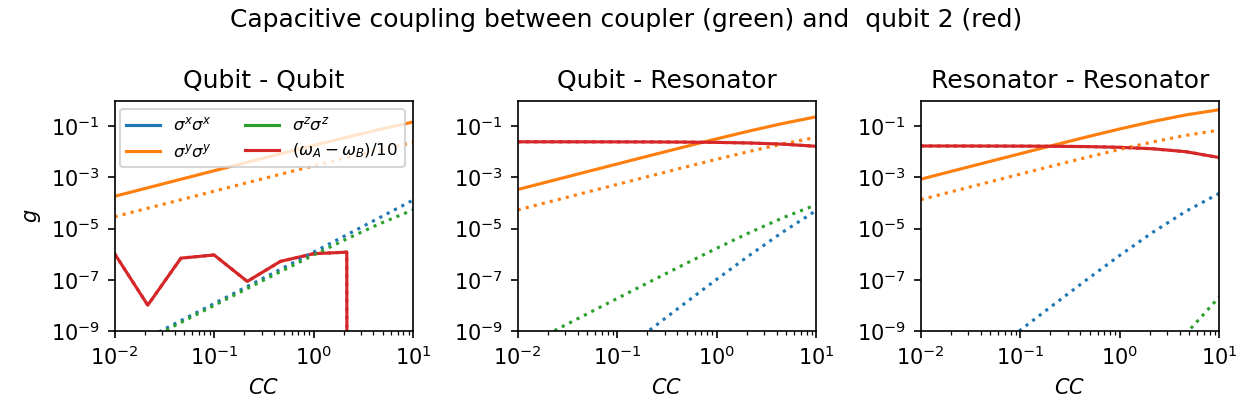

In [13]:
fig, axs = plt.subplots(ncols=3, figsize =np.array([3.5*3,3.5])*0.8, dpi=150)
linestyles = ['-', '--',':' ]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

colors = figs.generate_colors_from_colormap(10, 'tab10')

for j, (ax, Pauli_list, Δω, name, labels) in enumerate(zip(axs, [[FF_p1 , FF_p2 , FF_SWT], [FR_p1 , FR_p2 , FR_SWT], [RR_p1, RR_p2, RR_SWT]], [FF_Δω, FR_Δω, RR_Δω], names, labels_list)):
    for i, Pauli in enumerate(Pauli_list):
        if i ==1: 
            continue
        
        σxσx = np.abs(Pauli[:, 1,1])
        σyσy = np.abs(Pauli[:, 2,2])
        σzσz = np.abs(Pauli[:, 3,3])
    
        ax.plot(CC_values, σxσx,  color = colors[0], linestyle=linestyles[i], label = labels[0])
        ax.plot(CC_values, σyσy,  color = colors[1], linestyle=linestyles[i], label = labels[1])
        ax.plot(CC_values, σzσz,  color = colors[2], linestyle=linestyles[i], label = labels[2])
        ax.plot(CC_values, Δω/10, color = colors[3], linestyle=linestyles[i], label = r'$(\omega_A-\omega_B)/10$')
    
        # ax1.plot(Δ_values, g_fq_limit, 'x', color = colors[0], label = 'Fluxon limit', markersize='2')
        # ax1.plot(Δ_values, g_r_limit , 's', color = colors[0], label = 'Plasmon limit', markersize='2')
        if i ==0 and j ==0:
            ax.legend(ncol=2, fontsize=8)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-9,1e0])
        ax.set_xlim([1e-2,1e1])
        if j==0:
            ax.set_ylabel('$g$')
        # else:
        #     ax.set_yticks([])
        ax.set_xlabel('$CC$')
        
        ax.set_title(name)
    
# fig.suptitle(r' --- P1 $\quad \cdots$ SWT')
fig.suptitle(r'Capacitive coupling between coupler (green) and  qubit 2 (red) ')
fig.tight_layout()
figs.export('Capacitive_coupling_ops_vs_CC_coupler_and_qubit_2.pdf', fig)
fig.show()